In [38]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error,r2_score

In [39]:
PROCESSED_TRENDS_DB = "../db/trends_processed.db"
PROCESSED_TRENDS_TABLE = "trends_processed"

In [40]:
with sqlite3.connect(PROCESSED_TRENDS_DB) as con:
    df= pd.read_sql(f'SELECT * FROM {PROCESSED_TRENDS_TABLE}', con)

df.head(5)

,date,keyword,value
0,2024-08-25,washable,59
1,2024-09-01,washable,61
2,2024-09-08,washable,55
3,2024-09-15,washable,57
4,2024-09-22,washable,56


In [41]:
df = (
    df.groupby("keyword")
      .filter(lambda g: (g["value"].sum() > 0) and (g["value"].nunique() > 2))
)

In [42]:
df['date']=pd.to_datetime(df['date'])

In [43]:
df['t']= df.groupby("keyword").cumcount()



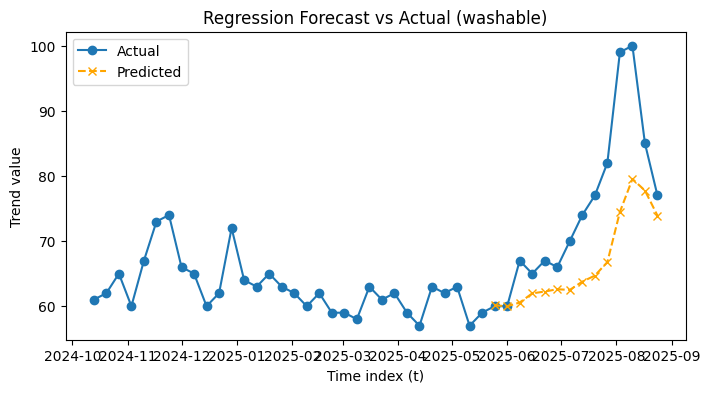

    keyword       rmse       mape        r2
0  washable  11.054958  10.260301  0.201574


In [44]:
results = []

for kw in df['keyword'].unique():
    df_kw = df[df['keyword'] == kw].reset_index(drop=True)

    df_kw = df[df['keyword'] == kw].copy().reset_index(drop=True)
    df_kw['lag_1'] = df_kw['value'].shift(1)
    df_kw['lag_7'] = df_kw['value'].shift(7)
    df_kw['roll_mean_7'] = df_kw['value'].rolling(7).mean()
    df_kw['roll_std_7'] = df_kw['value'].rolling(7).std()
    df_kw = df_kw.dropna()

    # time-aware split (on keyword subset, not whole df)
    train, test = train_test_split(df_kw, test_size=0.3, shuffle=False)
    
    x_train = train[['t','lag_1', 'lag_7', 'roll_mean_7', 'roll_std_7']].to_numpy()
    y_train = train['value'].to_numpy()
    x_test  = test[['t','lag_1', 'lag_7', 'roll_mean_7', 'roll_std_7']].to_numpy()
    y_test  = test['value'].to_numpy()

    # fit regression
    model = LinearRegression()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # add predictions as a new column
    test = test.copy()
    test['predicted'] = y_pred

    # metrics
    r_squared = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    results.append({
        'keyword': kw,
        'rmse': rmse,
        'mape': mape,
        'r2': r_squared
    })

    # plot
    plt.figure(figsize=(8,4))
    plt.plot(df_kw['date'], df_kw['value'], label='Actual', marker='o')
    plt.plot(test['date'], test['predicted'], label='Predicted', marker='x', linestyle='--', color='orange')
    plt.xlabel("Time index (t)")
    plt.ylabel("Trend value")
    plt.title(f"Regression Forecast vs Actual ({kw})")
    plt.legend()
    plt.show()

# summary metrics
results_df = pd.DataFrame(results)
print(results_df)